In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import graphviz
import os
from copy import deepcopy

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import pandas as pd
import numpy as np
import datetime as dt


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}


In [3]:
print(param_grid.keys())

dict_keys(['gamma', 'learning_rate', 'max_depth', 'n_estimators', 'reg_alpha', 'reg_lambda'])


In [51]:



class gridsearch_visual():
    '''
    #specify default model to use, e.g.:
    xgb_model_base = xgb.XGBClassifier(
        tree_method="hist",
        random_state = 9,
        objective='binary:logistic' )
    '''
    def __init__(self, classifer, X, y, param_grid, test_size=0.2, random_state=9, cv = 4, best_param_metric = "accuracy"):
        self.X = X
        self.y = y
        self.clf_base = classifer
        self.cv = cv
        self.grid_key = np.NAN
        self.grid_value = np.NAN

        self.best_param_metric = best_param_metric
        self.default_param = classifer.get_params()#self.param_to_list(classifer.get_params())    #to later throw into gridsearch
        self.default_param_0 = deepcopy(self.default_param)
        self.param_grid = param_grid   #specify in global 


        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state) # Default 80-20
        
        
        self.clf = GridSearchCV(estimator=self.clf_base, 
                                param_grid={},   #no hyper param grid
                                scoring=['accuracy', 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'f1', 'roc_auc', 'recall'], 
                                return_train_score=True, 
                                verbose=3, 
                                cv=self.cv, 
                                n_jobs= -1, 
                                refit = False).fit(self.X_train, self.y_train)  


        #self.metric_cache = {}    #self.train_and_evaluate()  
        self.results_dict = {'clf0' : self.clf.cv_results_} #initialize cache dict that would take in the metric number for later grid searcb
        self.best_hyper_param = {key: np.NaN for key in self.param_grid.keys()}



    def __repr__():
        pass




    def param_to_list(self, param_dict):
        #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
        param_dict_cleaned = {}
        for key in param_dict.keys():
            param_dict_cleaned[key] = [param_dict[key]]
        return param_dict_cleaned
    


    def train_and_evaluate(self, num, search_param, best_param_metric ):
        #self.clf_base.fit(self.X_train, self.y_train)  #train the classifier



        # update self.clf with param_grid 
        self.clf = GridSearchCV(estimator=self.clf_base, 
                                param_grid=search_param, 
                                scoring=['accuracy', 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'f1', 'roc_auc', 'recall'], 
                                return_train_score=True, 
                                verbose=3, 
                                cv=self.cv, 
                                n_jobs= -1, 
                                refit = best_param_metric)
        

        #self.y_train_pred = self.clf.predict(self.X_train)
        #self.y_val_pred = self.clf.predict(self.X_val)
        #print(self.clf_base)
        print(self.clf)
        print(search_param)
        #print(self.clf.best_params_)
        self.clf.fit(self.X_train, self.y_train)
        self.results_dict[f'clf{num+1}'] = self.clf.cv_results_
        self.best_hyper_param = {key: self.clf.best_params_[key] if key in self.clf.best_params_ else value for key, value in self.best_hyper_param.items()}


        # update default param to use the best hyperparam tuned 
        self.update_classifier()






    def update_classifier(self, custom_val_dict = None):
        # Update the classifier with new parameters either by a custom dictionary or by referencing the self.grid_key

        if custom_val_dict is None:
        #update the clf_base with updated default parameters to include the best tuned hyperparameter from self.best_hyper_param
            self.default_param[self.grid_key] = self.best_hyper_param[self.grid_key]
            print(self.default_param, "is updated with value", self.best_hyper_param[self.grid_key])

        elif custom_val_dict is not None:  
            try:
                assert set(custom_val_dict.keys()) <= set(self.param_grid.keys)
                assert all(isinstance(value, int) for value in custom_val_dict.values())

                self.default_param.update(custom_val_dict)

            except AssertionError:
                print("The parameters don't match or not all values are single integers.")


        self.clf_base.set_params(**self.default_param)
        #self.clf_base = self.clf_base.fit(self.X_train, self.y_train)

  



    def hyperparameter_tune_grid_search(self):
    #this should populate self.results_dict and self.best_hyper_param


        for index, (grid_key, values) in enumerate(self.param_grid.items()):
         
            self.grid_key = grid_key
            self.grid_value = values
            print(self.grid_key)
            self.train_and_evaluate(index, {grid_key: values}, self.best_param_metric)

    




    def visualize_h_param(self, metric = None):
        if metric is None:
            metric = self.best_param_metric


        nrows = len(self.results_dict.keys())
        print(nrows)
        print(self.results_dict.keys())
        #group_names = ['True Neg','False Pos','False Neg','True Pos']


        fig, ax = plt.subplots(nrows,3,figsize=(27,8*nrows))

        for row in range(nrows):

            clf_number = list(self.results_dict.keys())[row] 
            print(clf_number)


            if clf_number != 'clf0':
                hyper_param_name = [key for item in self.results_dict[clf_number]['params'] for key in item.keys()][0]
            #data_range = range(int(min(param_grid[hyper_param_name])), int(max(param_grid[hyper_param_name])))
                data_range = param_grid[hyper_param_name]
        
                print(clf_number, hyper_param_name)
        
        
            #metric
                y1 = self.results_dict[clf_number]['mean_train_accuracy']#.loc[:,'mean_train_score']
                y2 = self.results_dict[clf_number]['mean_test_accuracy']#.loc[:,'mean_test_score']
                x = np.arange(len(data_range))

                print(y1)
                print(y2)
                print(x)


                ax[row, 0].plot(x, y1, label='Train scores', color='blue')
                ax[row, 0].plot(x, y2, label='Validation scores', color='red')
                #ax[row, 0].set_title(f'Iteration #{i+1} results')
                ax[row, 0].set_title(f'Iteration #{row+1} metric')


                ax[row, 0].set_xticks(x)
                ax[row, 0].set_xticklabels([str(value) for value in data_range])


                ax[row, 0].grid('major')
                ax[row, 0].legend()
                ax[row, 0].set_xlabel(hyper_param_name)
                ax[row, 0].set_ylabel('mean score')



            #run time
                y3 = self.results_dict[clf_number]['mean_fit_time']#.loc[:,'mean_train_score']
                ax[row, 1].plot(x, y2, label='test scores', color='red')
                #ax[row, 1].set_title(f'Iteration #{i+1} results')
                ax[row, 1].set_title(f'Iteration #{row+1} runtime')
        
                ax[row, 1].set_xticks(x)
                ax[row, 1].set_xticklabels([str(value) for value in data_range])

                ax[row, 1].grid('major')
                #ax[row, 1].legend()
                ax[row, 1].set_xlabel(hyper_param_name)
                ax[row, 1].set_ylabel('seconds')

            else:
                ax[row, 0].axis('off')
                ax[row, 0].text(x=0.5, y=0.5, s='No iteration has been performed; accuracy: ' + str(np.round(self.results_dict['clf0']['mean_test_accuracy'][0], decimals=2)), fontsize=16, va='center', ha='center')


        #run time
                ax[row, 1].axis('off')
                ax[row, 1].text(x=0.5, y=0.5, s="run time: " + str(np.round(self.results_dict['clf0']['mean_fit_time'][0], decimals=2))+" seconds", fontsize=16, va='center', ha='center')

        plt.show()

        
    def update_parameters
    

    


#class visuals(metrics, gridsearch_visual):

In [52]:
import math
xgb_model_base = xgb.XGBClassifier(
        tree_method="hist",
        random_state = 9,
        objective='binary:logistic' )
X = np.random.rand(1000, 30)
y = np.random.randint(0, 2, size=(1, 1000)).T
test_class = gridsearch_visual(xgb_model_base, X, y, param_grid)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [53]:
xgb_model_base.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 9,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [54]:
test_class.clf_base.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 9,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [55]:
test_class.clf.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__multi_strategy': None,
 'estimator

In [56]:
test_class.results_dict

{'clf0': {'mean_fit_time': array([0.23946065]),
  'std_fit_time': array([0.00148019]),
  'mean_score_time': array([0.01326203]),
  'std_score_time': array([0.0044968]),
  'params': [{}],
  'split0_test_accuracy': array([0.515]),
  'split1_test_accuracy': array([0.445]),
  'split2_test_accuracy': array([0.52]),
  'split3_test_accuracy': array([0.465]),
  'mean_test_accuracy': array([0.48625]),
  'std_test_accuracy': array([0.03208874]),
  'rank_test_accuracy': array([1]),
  'split0_train_accuracy': array([1.]),
  'split1_train_accuracy': array([1.]),
  'split2_train_accuracy': array([1.]),
  'split3_train_accuracy': array([1.]),
  'mean_train_accuracy': array([1.]),
  'std_train_accuracy': array([0.]),
  'split0_test_balanced_accuracy': array([0.51381243]),
  'split1_test_balanced_accuracy': array([0.44374937]),
  'split2_test_balanced_accuracy': array([0.52076869]),
  'split3_test_balanced_accuracy': array([0.46316685]),
  'mean_test_balanced_accuracy': array([0.48537434]),
  'std_test

In [57]:
test_class.hyperparameter_tune_grid_search()

gamma
GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 3.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 9, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}
learning_rate
GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
 

In [58]:
test_class.clf.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': 3.2,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': 0.3,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': 6,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__multi_strategy': None,
 'estimator__n_e

In [59]:
test_class.results_dict

{'clf0': {'mean_fit_time': array([0.23946065]),
  'std_fit_time': array([0.00148019]),
  'mean_score_time': array([0.01326203]),
  'std_score_time': array([0.0044968]),
  'params': [{}],
  'split0_test_accuracy': array([0.515]),
  'split1_test_accuracy': array([0.445]),
  'split2_test_accuracy': array([0.52]),
  'split3_test_accuracy': array([0.465]),
  'mean_test_accuracy': array([0.48625]),
  'std_test_accuracy': array([0.03208874]),
  'rank_test_accuracy': array([1]),
  'split0_train_accuracy': array([1.]),
  'split1_train_accuracy': array([1.]),
  'split2_train_accuracy': array([1.]),
  'split3_train_accuracy': array([1.]),
  'mean_train_accuracy': array([1.]),
  'std_train_accuracy': array([0.]),
  'split0_test_balanced_accuracy': array([0.51381243]),
  'split1_test_balanced_accuracy': array([0.44374937]),
  'split2_test_balanced_accuracy': array([0.52076869]),
  'split3_test_balanced_accuracy': array([0.46316685]),
  'mean_test_balanced_accuracy': array([0.48537434]),
  'std_test

In [60]:
#hyper_param_list = [key for key in param_grid.keys()]
param_grid["gamma"]

[0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]

7
dict_keys(['clf0', 'clf1', 'clf2', 'clf3', 'clf4', 'clf5', 'clf6'])
clf0
clf1
clf1 gamma
[1.         1.         1.         1.         1.         0.99208333
 0.92875    0.73291667 0.515      0.515      0.515      0.515
 0.515     ]
[0.48625 0.48375 0.48    0.505   0.48125 0.4825  0.5375  0.48625 0.515
 0.515   0.515   0.515   0.515  ]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
clf2
clf2 learning_rate
[0.95583333 0.95416667 0.95208333 0.94958333 0.95458333 0.93541667
 0.93208333 0.92875    0.91375    0.9175     0.91791667 0.92458333]
[0.49375 0.4875  0.49625 0.5     0.50625 0.5275  0.49875 0.5375  0.515
 0.48    0.48    0.4925 ]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
clf3
clf3 max_depth
[0.90541667 0.92875    0.94333333 0.94375    0.95041667 0.95166667
 0.95208333 0.95208333 0.95208333 0.95208333]
[0.49125 0.5375  0.50375 0.49625 0.49    0.51125 0.51    0.50625 0.50625
 0.50625]
[0 1 2 3 4 5 6 7 8 9]
clf4
clf4 n_estimators
[0.92875 0.92875 0.92875 0.92875 0.92875 0.92875 0.92875]
[0.5375 

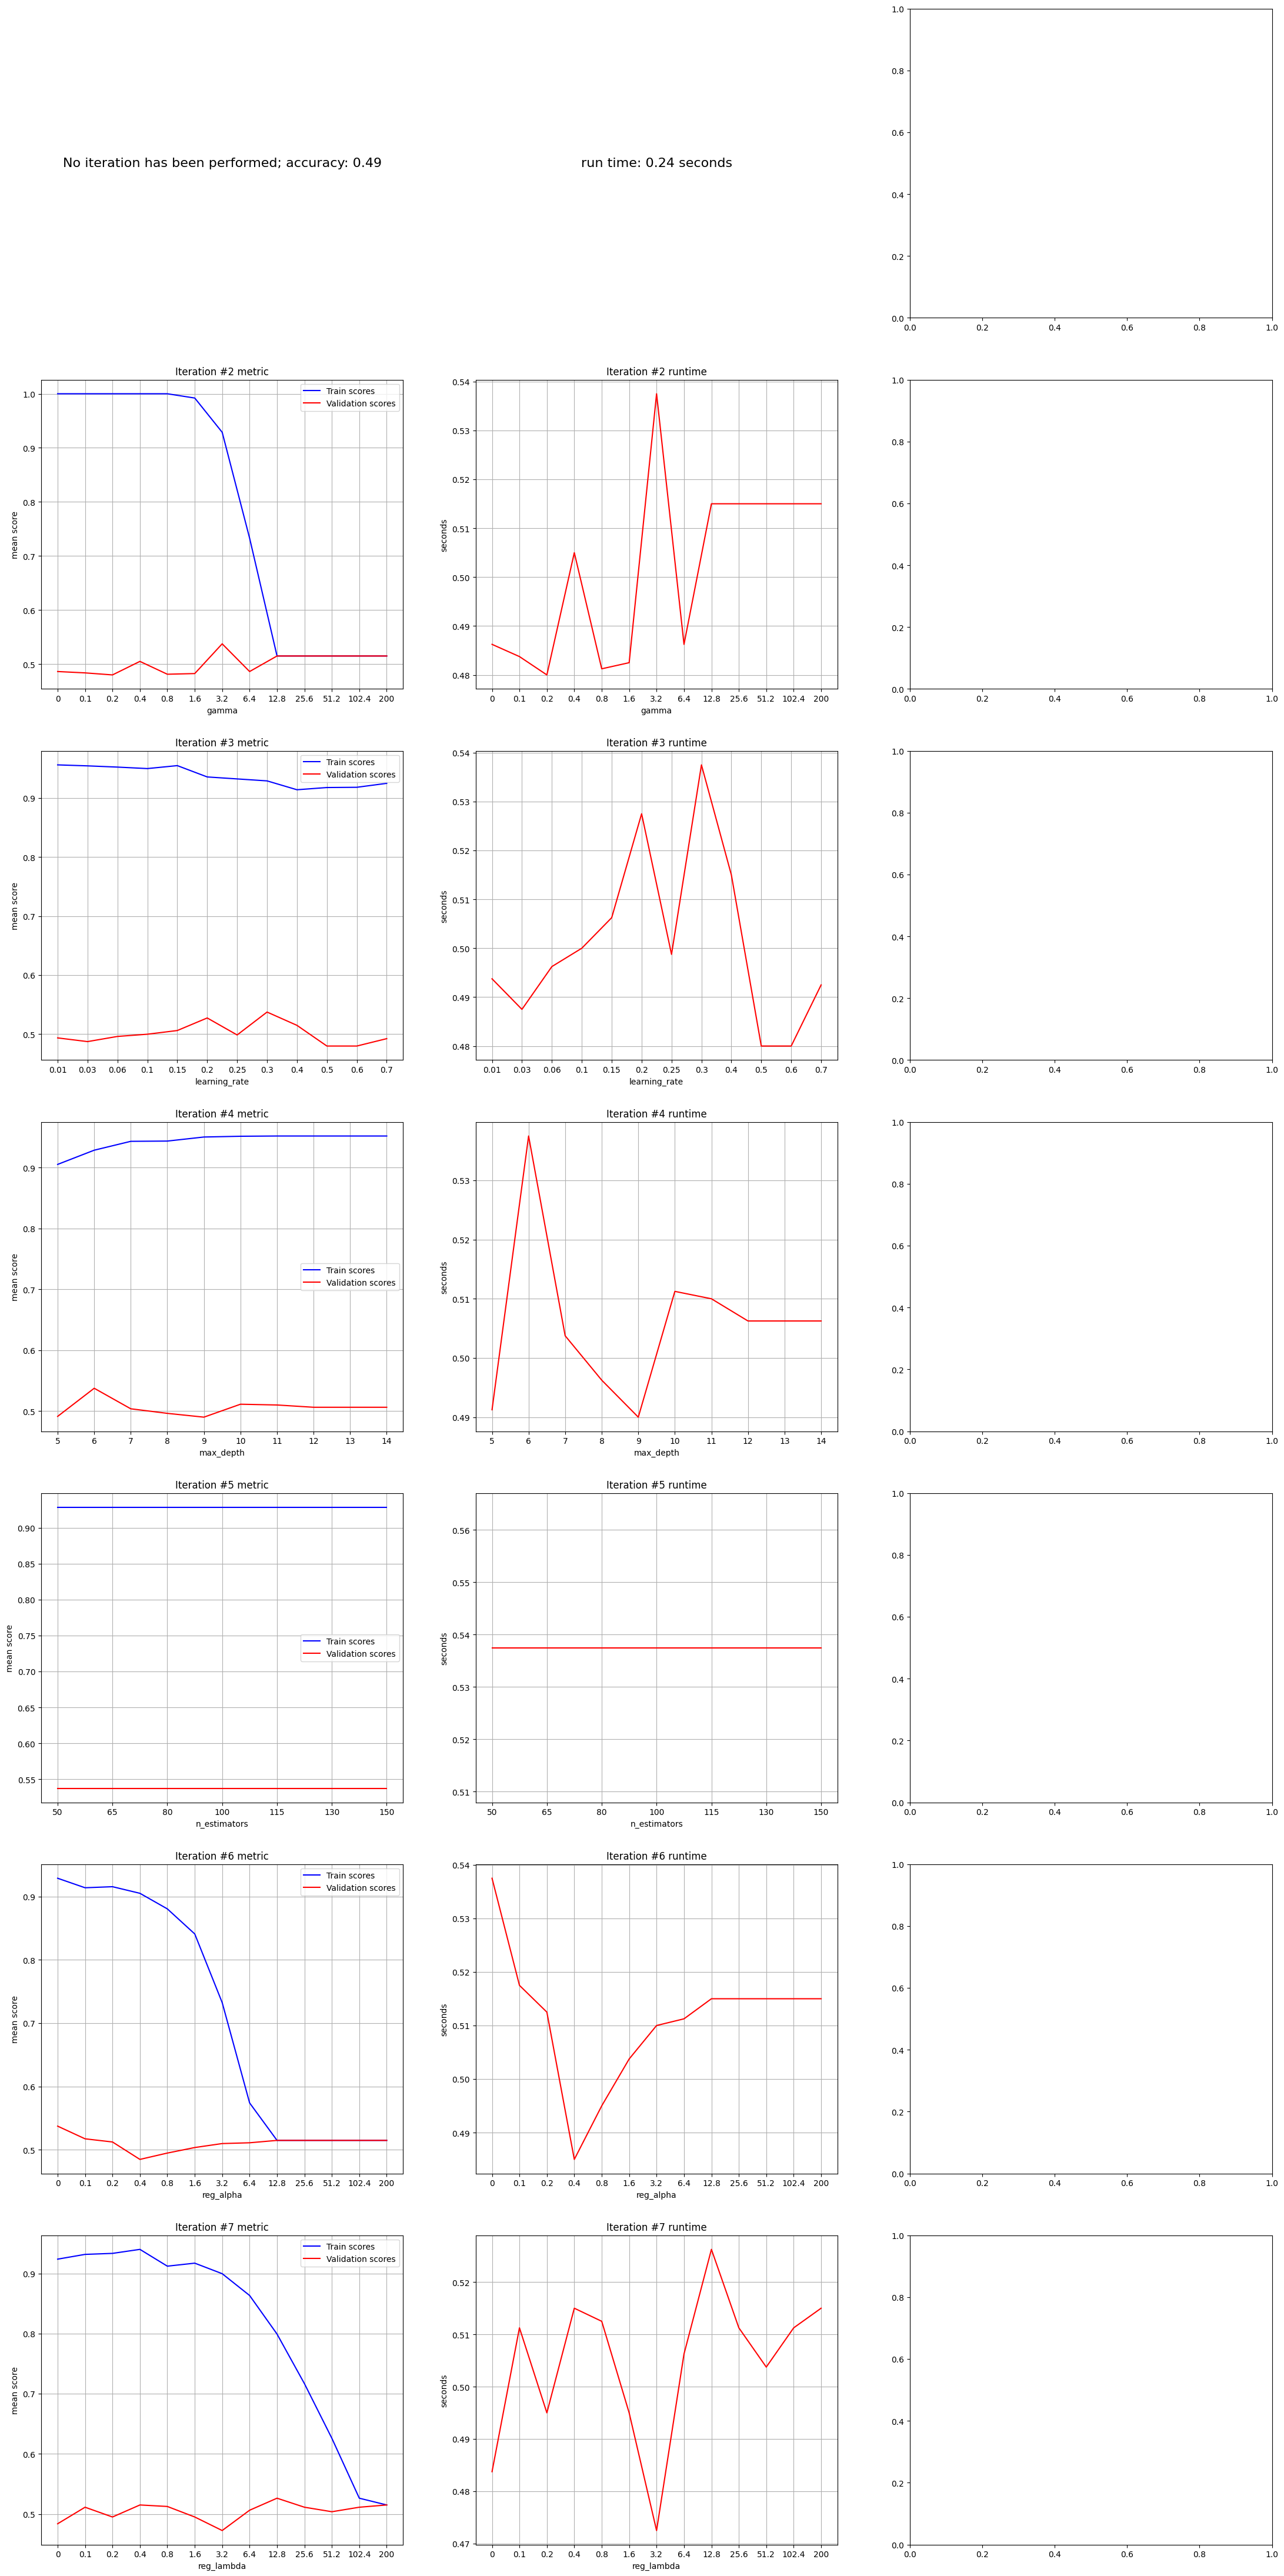

In [61]:
test_class.hyper_param_visualize()

clf1 gamma
clf2 learning_rate
clf3 max_depth
clf4 n_estimators
clf5 reg_alpha
clf6 reg_lambda


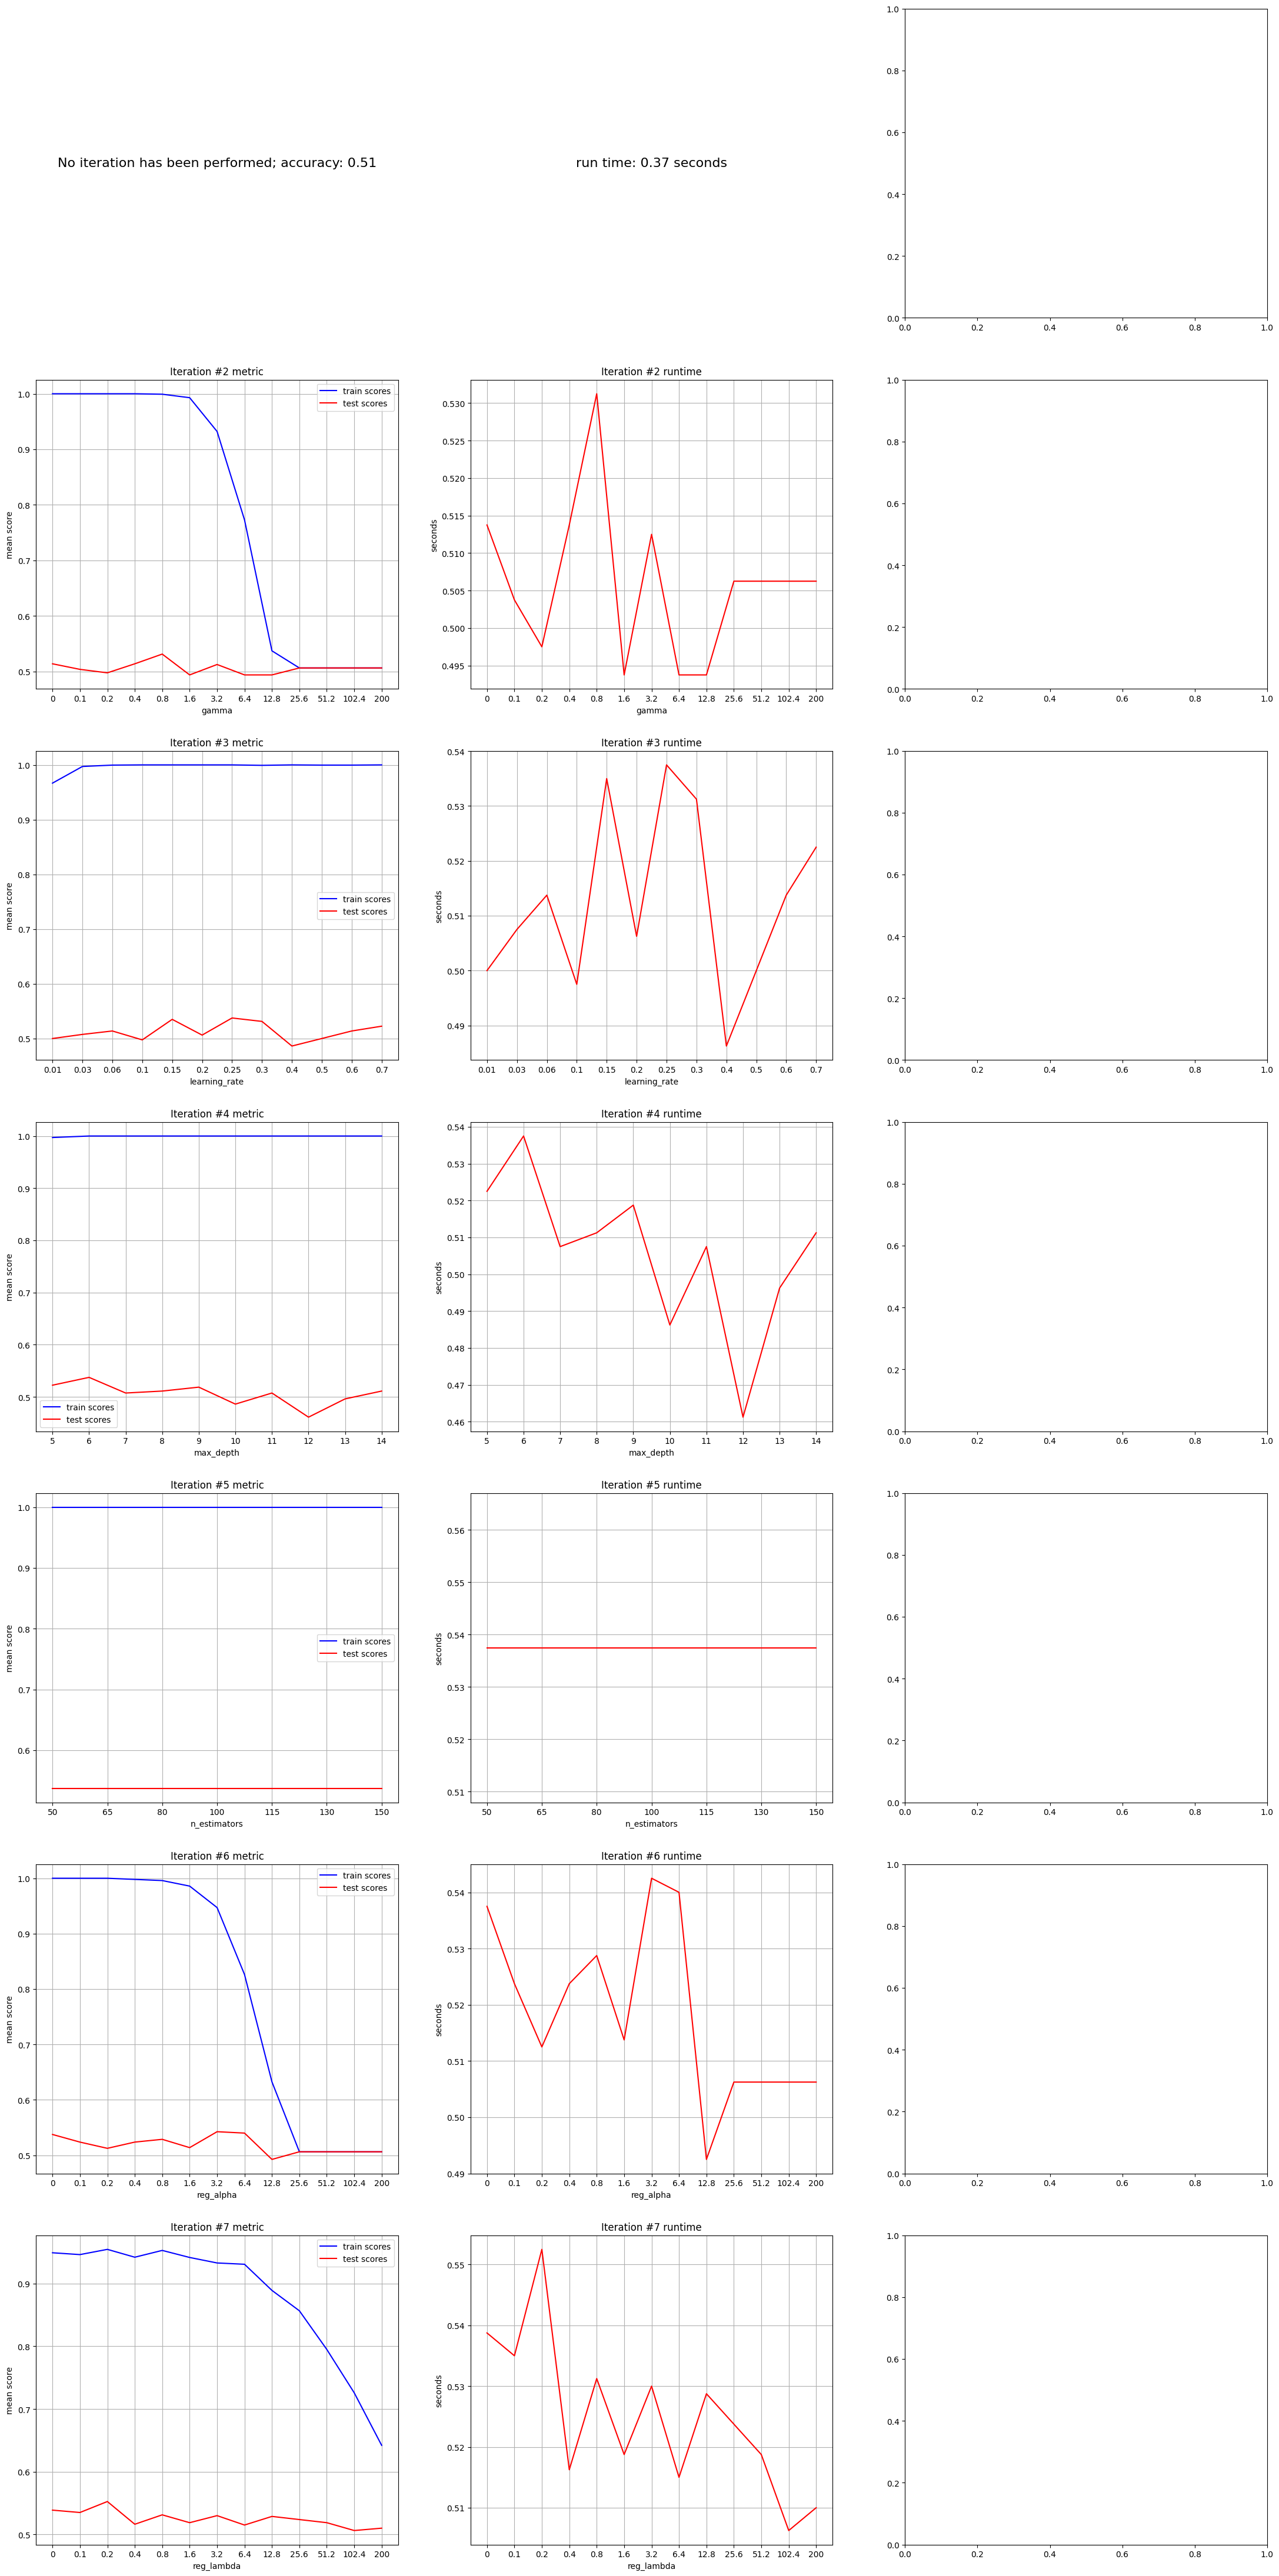

In [78]:
results_dict = test_class.results_dict
nrows = len(results_dict.keys())

group_names = ['True Neg','False Pos','False Neg','True Pos']


fig, ax = plt.subplots(nrows,3,figsize=(27,8*nrows))

for row in range(nrows):

    clf_number = list(results_dict.keys())[row] 


    if clf_number != 'clf0':
        hyper_param_name = [key for item in results_dict[clf_number]['params'] for key in item.keys()][0]
        #data_range = range(int(min(param_grid[hyper_param_name])), int(max(param_grid[hyper_param_name])))
        data_range = param_grid[hyper_param_name]
        
        print(clf_number, hyper_param_name)
        
        
        #metric
        y1 = results_dict[clf_number]['mean_train_accuracy']#.loc[:,'mean_train_score']
        y2 = results_dict[clf_number]['mean_test_accuracy']#.loc[:,'mean_test_score']
        x = np.arange(len(data_range))


        ax[row, 0].plot(x, y1, label='train scores', color='blue')
        ax[row, 0].plot(x, y2, label='test scores', color='red')
        #ax[row, 0].set_title(f'Iteration #{i+1} results')
        ax[row, 0].set_title(f'Iteration #{row+1} metric')


        ax[row, 0].set_xticks(x)
        ax[row, 0].set_xticklabels([str(value) for value in data_range])


        ax[row, 0].grid('major')
        ax[row, 0].legend()
        ax[row, 0].set_xlabel(hyper_param_name)
        ax[row, 0].set_ylabel('mean score')



        #run time
        y3 = results_dict[clf_number]['mean_fit_time']#.loc[:,'mean_train_score']
        ax[row, 1].plot(x, y2, label='test scores', color='red')
        #ax[row, 1].set_title(f'Iteration #{i+1} results')
        ax[row, 1].set_title(f'Iteration #{row+1} runtime')
        
        ax[row, 1].set_xticks(x)
        ax[row, 1].set_xticklabels([str(value) for value in data_range])

        ax[row, 1].grid('major')
        #ax[row, 1].legend()
        ax[row, 1].set_xlabel(hyper_param_name)
        ax[row, 1].set_ylabel('seconds')

    else:
        ax[row, 0].axis('off')
        ax[row, 0].text(x=0.5, y=0.5, s='No iteration has been performed; accuracy: ' + str(np.round(results_dict['clf0']['mean_test_accuracy'][0], decimals=2)), fontsize=16, va='center', ha='center')


        #run time
        ax[row, 1].axis('off')
        ax[row, 1].text(x=0.5, y=0.5, s="run time: " + str(np.round(results_dict['clf0']['mean_fit_time'][0], decimals=2))+" seconds", fontsize=16, va='center', ha='center')

    #confusion matrix
    #cm = confusion_matrix()
plt.show()

clf1
[1.         1.         1.         1.         0.99916667 0.99291667
 0.93208333 0.77291667 0.53708333 0.50625    0.50625    0.50625
 0.50625   ] [0.51375 0.50375 0.4975  0.51375 0.53125 0.49375 0.5125  0.49375 0.49375
 0.50625 0.50625 0.50625 0.50625]
gamma
[0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]
clf2
[0.96666667 0.99708333 0.99958333 1.         1.         1.
 1.         0.99916667 1.         0.99958333 0.99958333 1.        ] [0.5     0.5075  0.51375 0.4975  0.535   0.50625 0.5375  0.53125 0.48625
 0.5     0.51375 0.5225 ]
learning_rate
[0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
clf3
[0.99708333 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ] [0.5225  0.5375  0.5075  0.51125 0.51875 0.48625 0.5075  0.46125 0.49625
 0.51125]
max_depth
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
clf4
[1. 1. 1. 1. 1. 1. 1.] [0.5375 0.5375 0.5375 0.5375 0.5375 0.5375 0.5375]
n_estimators
[50, 65, 80, 100, 115, 130,

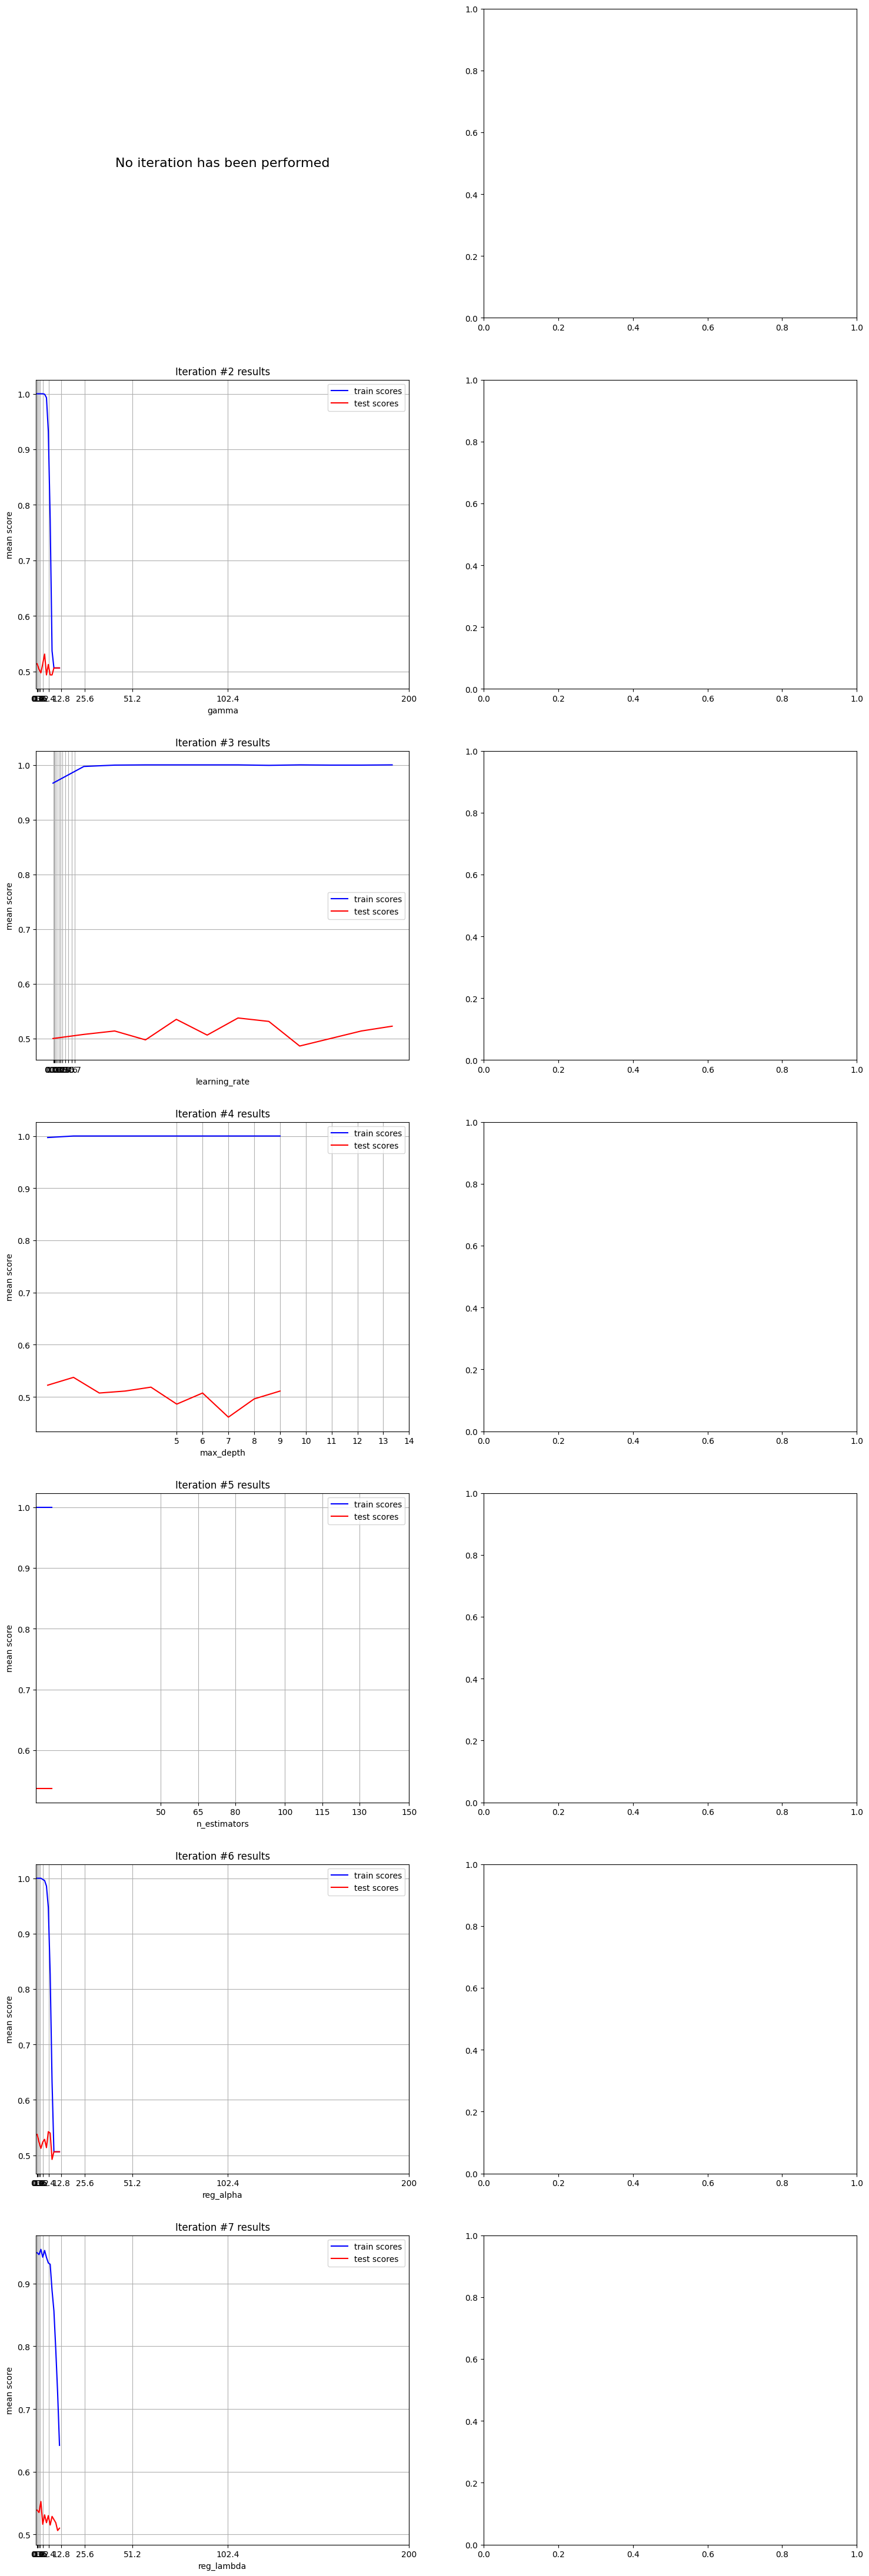

In [49]:
results_dict = test_class.results_dict


#hyper_param_list = [key for key in param_grid.keys()]

#number of rows depend on number of iterations
nrows = len(results_dict.keys())


#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    

    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'clf0':
        print(ckey)
        #h_param = hyper_param_list[i]

        x1 = results_dict[ckey]['mean_train_accuracy']#.loc[:,'mean_train_score']
        x2 = results_dict[ckey]['mean_test_accuracy']#.loc[:,'mean_test_score']
        print(x1, x2)
        ax[0].plot(x1, label='train scores', color='blue')
        ax[0].plot(x2, label='test scores', color='red')
        ax[0].set_title(f'Iteration #{i+1} results')



        hyper_param_name = [key for item in results_dict[ckey]['params'] for key in item.keys()][0]
        print(hyper_param_name)
        print(param_grid[hyper_param_name])

        data_range = range(int(min(param_grid[hyper_param_name])), int(max(param_grid[hyper_param_name])))
        


        ax[0].set_xticks(param_grid[hyper_param_name])
        ax[0].set_xticklabels([str(value) for value in param_grid[hyper_param_name]])
    
        #ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        #ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(hyper_param_name)
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    #group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    #group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    #labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    #labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    #sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();